In [1]:
import copy
import bokeh
from bokeh.plotting import show

import numpy as np
import pandas as pd
import math
import os
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cProfile
import matplotlib.transforms as transforms

import flowkit as fk
import glob as glob

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

Loading BokehJS ...

In [42]:
list = np.sort(glob.glob('/Users/aryellewright/Documents/Documents - Aryelle’s MacBook Air/Kumar-Biomaterials-Lab/CellUptake_Plots/Cell Uptake_Aryelle Experiment_02.09.2024/DIPLibrary_NP5NP7.5/*.fcs'))
fcs_path = list[32]
sample = fk.Sample(fcs_path)
sample

Sample(v3.1, D3 LPF 2000_003.fcs, 51 channels, 21641 events)

In [43]:
df_events = sample.as_dataframe(source='raw')

f = sample.plot_scatter('FSC-A', 'SSC-A', source='raw')
show(f)

In [44]:
SSC_idx = sample.get_channel_index('SSC-A')
FSC_idx = sample.get_channel_index('FSC-A')
events_SSC= sample.get_channel_events(SSC_idx,source = 'raw')
events_FSC= sample.get_channel_events(FSC_idx,source = 'raw')

g_strat = fk.GatingStrategy()

dim_SSC = fk.Dimension('SSC-A')
dim_FSC = fk.Dimension('FSC-A')

In [5]:
vertices = [
    (1490000,500000),
    (2456000,875200),
    (2898000,1586000),
    (2790000,2251000),
    (183900,2783000),
    (539600,2889000),
    (292800,1952000),
    (409000,900300),
    (721000,500800)
]

poly_gate = fk.gates.PolygonGate(
    'Cells', 
    dimensions=[dim_FSC, dim_SSC],
    vertices=vertices
)

In [6]:
g_strat.add_gate(poly_gate, gate_path=('root',))
res = g_strat.gate_sample(sample)

res.report

sample gate_path gate_name    gate_type quadrant_parent parent  \
0  D6 S10-3.fcs   (root,)     Cells  PolygonGate            None   root   

   count  absolute_percent  relative_percent  level  
0  14300         78.261821         78.261821      1

In [7]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('Cells')

p = sample.plot_scatter(
    'FSC-A', 'SSC-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [8]:
gs_results = g_strat.gate_sample(sample, verbose=True)

cell_gate_membership = gs_results.get_gate_membership('Cells')
cell_gate_membership.sum()

D6 S10-3.fcs: processing gate Cells


14300

In [9]:
def gated_cells (fcs_df, cell_gate_membership_array):
    """This function allows takes in a binary array for cell membership to a gate, along
    with the original dataframe from all the gates cells, and outputs a datafram that only
    include the values relavent to the cells containted within that gate"""

    #intializes column title array as well as the array to store filtered values
    titles = fcs_df.columns.values
    array_for_df = []

    #loops through titles filtering for cells that are contained within the gate
    for i in titles:
        array = df_events[i]
        new_array = []
        for i in range(len(array)):
            if cell_gate_membership_array[i]:
                new_array.append(array[i])

        array_for_df.append(new_array)

    #intializing dictionary to create data frame from
    d = {}

    #matching data with titles in dictionary for dataframe creation
    for i in range(len(titles)):
        d[titles[i]]= array_for_df[i]

    #creating dataframe
    df = pd.DataFrame(d)
    
    return df

In [10]:
cells_df = gated_cells(df_events, cell_gate_membership)
cells_df

Time        FSC-W      FSC-H         FSC-A         SSC-W  \
                                                                      
0        0.0000  762417.0000  1508105.0  1.916341e+06  1.050446e+06   
1        0.0091  728768.1875  1510946.0  1.835216e+06  9.558986e+05   
2        0.0144  672042.5000  1494578.0  1.674033e+06  9.690351e+05   
3        0.0223  751752.9375  1475643.0  1.848865e+06  9.340373e+05   
4        0.0237  588711.1875   924347.0  9.069557e+05  8.093668e+05   
...         ...          ...        ...           ...           ...   
14295  249.6090  878949.8125   486818.0  7.131476e+05  1.079370e+06   
14296  249.7642  795645.0625   477866.0  6.336862e+05  1.086253e+06   
14297  249.8248  897823.5000   415801.0  6.221932e+05  1.320770e+06   
14298  249.8256  840494.3750   386996.0  5.421132e+05  1.345528e+06   
14299  249.8262  669330.6250   812378.0  9.062491e+05  9.279798e+05   

           SSC-H         SSC-A        B1-H       B1-A        B2-H  ...  \
                                                                   ...   
0       745838.0  1.305770e+06  168.500000  62.340378  175.199997  ...   
1      1032448.0  1.644859e+06   91.300003  48.201748   88.800003  ...   
2       717875.0  1.159410e+06  145.199997  50.352375  102.800003  ...   
3      1214972.0  1.891382e+06  115.599998  40.591316   98.800003  ...   
4       731430.0  9.866585e+05  113.000000  62.992500   97.599998  ...   
...          ...           ...         ...        ...         ...  ...   
14295   727783.0  1.309245e+06   62.700001  21.221813   92.099998  ...   
14296   755464.0  1.367708e+06  105.599998  50.470314   98.200005  ...   
14297   405535.0  8.926971e+05  115.099998  33.653812  108.500000  ...   
14298   377993.0  8.476672e+05   97.900002  44.642815   91.900002  ...   
14299   405332.0  6.268998e+05   80.500000 -28.554750   96.500000  ...   

           R4-H           R4-A      R5-H           R5-A     R6-H  \
                                                                   
0         700.0     248.947495     686.0    -214.177490    393.0   
1         950.0     292.125000    1595.0     536.085022    960.0   
2        2769.0    1007.047485    3605.0    1675.942505   2330.0   
3        1092.0     463.338745    1288.0     595.792480    570.0   
4         192.0      76.237495     362.0     -29.141249    474.0   
...         ...            ...       ...            ...      ...   
14295    1339.0    1617.731201     959.0    1364.864990    614.0   
14296   34527.0   64643.199219   26514.0   50756.363281  16613.0   
14297   22128.0   38378.953125   16580.0   29445.273438  10202.0   
14298   84694.0  131501.421875   63457.0   99366.601562  40207.0   
14299  190533.0  224236.921875  138563.0  174388.500000  88707.0   

                R6-A     R7-H          R7-A     R8-H          R8-A  
                                                                    
0         127.680000    352.0    115.353752   1035.0    278.017487  
1         277.946259    312.0   -289.488739    560.0    593.156250  
2        1063.192505   1433.0    114.427498   1085.0     78.232498  
3         160.383743    481.0    531.667480    481.0     98.894997  
4          40.327499    161.0    -35.482498    487.0     15.318749  
...              ...      ...           ...      ...           ...  
14295     945.558716    429.0    645.881226    684.0    591.089966  
14296   31729.191406  13098.0  24546.408203   6098.0  11751.191406  
14297   18647.833984   8293.0  14522.602539   3872.0   6837.007324  
14298   62504.132812  31635.0  49040.304688  14877.0  22520.414062  
14299  109736.828125  71433.0  84903.921875  31753.0  39517.246094  

[14300 rows x 51 columns]

In [11]:
sample = fk.Sample(cells_df, sample_id='Cells Gate')
f = sample.plot_scatter('SSC-A', 'SSC-H', source='raw')
show(f)

In [12]:
dim_SSC_A = fk.Dimension('SSC-A')
dim_SSC_H = fk.Dimension('SSC-H')


In [13]:
center = (1500000, 700000)
cov = [[9.74944434e+11, 4.92652573e+11], [4.92652573e+11, 2.82662600e+11]]
dist = 1000000

ellipse_gate = fk.gates.EllipsoidGate(
    'Singlet', 
    dimensions=[dim_SSC_A, dim_SSC_H], 
    coordinates=center,
    covariance_matrix=cov,
    distance_square=dist
)
g_strat.add_gate(ellipse_gate, gate_path=('root','Cells'))
res = g_strat.gate_sample(sample)
res.report

sample      gate_path gate_name      gate_type quadrant_parent parent  \
0  Cells Gate        (root,)     Cells    PolygonGate            None   root   
1  Cells Gate  (root, Cells)   Singlet  EllipsoidGate            None  Cells   

   count  absolute_percent  relative_percent  level  
0  14300             100.0             100.0      1  
1  14300             100.0             100.0      2

In [14]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('Singlet')

In [15]:
p = sample.plot_scatter(
    'SSC-A', 'SSC-H', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [16]:
quad_div1 = fk.QuadrantDivider(
    'Cellular Uptake',
    'R3-A',
    compensation_ref='uncompensated', 
    transformation_ref=None, 
    values=[2500]
)

quad_divs = [quad_div1]

# the 2 dividers above will be used to divide the space into 4 quadrants
quad_1 = fk.gates.Quadrant(
    quadrant_id='Cy5 positive',
    divider_refs=['Cellular Uptake'],
    divider_ranges=[(3000, None)]
)
quad_3 = fk.gates.Quadrant(
    quadrant_id='Cy5 negative',
    divider_refs=['Cellular Uptake'],
    divider_ranges=[(None, 3000)]
)

quadrants = [quad_1, quad_3]

# We can now construct our QuadrantGate
quad_gate1 = fk.gates.QuadrantGate(
    'Viability Gate', 
    dividers=quad_divs, 
    quadrants=quadrants
)

In [17]:
g_strat.add_gate(quad_gate1, gate_path=('root','Cells','Singlet',))
res = g_strat.gate_sample(sample)

In [18]:
res.report

sample               gate_path     gate_name      gate_type  \
0  Cells Gate                 (root,)         Cells    PolygonGate   
1  Cells Gate           (root, Cells)       Singlet  EllipsoidGate   
3  Cells Gate  (root, Cells, Singlet)  Cy5 negative   QuadrantGate   
2  Cells Gate  (root, Cells, Singlet)  Cy5 positive   QuadrantGate   

  quadrant_parent   parent  count  absolute_percent  relative_percent  level  
0            None     root  14300        100.000000        100.000000      1  
1            None    Cells  14300        100.000000        100.000000      2  
3  Viability Gate  Singlet    178          1.244755          1.244755      3  
2  Viability Gate  Singlet  14122         98.755245         98.755245      3

In [19]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('Cy5 positive')

In [20]:
p = sample.plot_scatter(
    'R2-A', 'B2-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [21]:
quad_div2 = fk.QuadrantDivider(
    'Transfection',
    'B2-A',
    compensation_ref='uncompensated', 
    transformation_ref=None, 
    values=[2500]
)

quad_divs = [quad_div2]

# the 2 dividers above will be used to divide the space into 4 quadrants
quad_2 = fk.gates.Quadrant(
    quadrant_id='GFP Positive Cells',
    divider_refs=['Transfection'],
    divider_ranges=[(10000, None)]
)
quad_4 = fk.gates.Quadrant(
    quadrant_id='GFP Negative Cells',
    divider_refs=['Transfection'],
    divider_ranges=[(None, 10000)]
)

quadrants = [quad_2, quad_4]

# We can now construct our QuadrantGate
quad_gate2 = fk.gates.QuadrantGate(
    'Transfection Gate', 
    dividers=quad_divs, 
    quadrants=quadrants
)

In [22]:
g_strat.add_gate(quad_gate2, gate_path=('root','Cells','Singlet','Viability Gate','Cy5 positive',))
res = g_strat.gate_sample(sample)

In [23]:
res.report

sample                                          gate_path  \
0  Cells Gate                                            (root,)   
1  Cells Gate                                      (root, Cells)   
3  Cells Gate                             (root, Cells, Singlet)   
2  Cells Gate                             (root, Cells, Singlet)   
5  Cells Gate  (root, Cells, Singlet, Viability Gate, Cy5 pos...   
4  Cells Gate  (root, Cells, Singlet, Viability Gate, Cy5 pos...   

            gate_name      gate_type    quadrant_parent        parent  count  \
0               Cells    PolygonGate               None          root  14300   
1             Singlet  EllipsoidGate               None         Cells  14300   
3        Cy5 negative   QuadrantGate     Viability Gate       Singlet    178   
2        Cy5 positive   QuadrantGate     Viability Gate       Singlet  14122   
5  GFP Negative Cells   QuadrantGate  Transfection Gate  Cy5 positive  14008   
4  GFP Positive Cells   QuadrantGate  Transfection Gate  Cy5 positive    114   

   absolute_percent  relative_percent  level  
0        100.000000        100.000000      1  
1        100.000000        100.000000      2  
3          1.244755          1.244755      3  
2         98.755245         98.755245      3  
5         97.958042         99.192749      5  
4          0.797203          0.807251      5

In [24]:
text = g_strat.get_gate_hierarchy(output='ascii')

In [25]:
print(text)

root
╰── Cells
    ╰── Singlet
        ╰── Viability Gate
            ├── Cy5 positive
            │   ╰── Transfection Gate
            │       ├── GFP Positive Cells
            │       ╰── GFP Negative Cells
            ╰── Cy5 negative


In [26]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('GFP Positive Cells')

In [27]:
p = sample.plot_scatter(
    'B2-A', 'SSC-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [28]:
def get_file_name(file_path):
    """Given a file path this function finds the file name without the extension"""
    # This will give you the last component of the file path
    file_name_with_extension = os.path.basename(file_path)
    file_name = os.path.splitext(file_name_with_extension)[0]
    return file_name

def modify_file_name(file_path):
    file_name = os.path.basename(file_path)
    # Modify the file_name to remove undesired parts for sorting
    # Adjust the regex according to your file naming conventions
    modified_name = re.sub(r'^[A-Z]\d+\s+', '', file_name)
    modified_name = os.path.splitext(modified_name)[0]  # Optionally remove the file extension
    return modified_name

def geometric_mean(arr):
    """This function calculates the geometric mean of a array, utilizing logarithm rules 
    to minimize the computational size"""
    n = len(arr)
    log_sum = 0
    N = len(arr)
    count = 0

    
    for num in arr:
        if num <= 0:
            count +=1
        else:
            log_sum += math.log(num)

    n = len(arr)-count 
    
    return (math.exp(log_sum / n)),count, N

def gated_cells (fcs_df, cell_gate_membership_array):
    """This function allows takes in a binary array for cell membership to a gate, along
    with the original dataframe from all the gates cells, and outputs a datafram that only
    include the values relavent to the cells containted within that gate"""

    #intializes column title array as well as the array to store filtered values
    titles = fcs_df.columns.values
    array_for_df = []

    #loops through titles filtering for cells that are contained within the gate
    for i in titles:
        array = fcs_df[i]
        new_array = []

        for i in range(len(cell_gate_membership_array)):  # Ensures loop does not exceed array size
            if cell_gate_membership_array[i]:
                new_array.append(array[i])

        array_for_df.append(new_array)



    #intializing dictionary to create data frame from
    d = {}

    #matching data with titles in dictionary for dataframe creation
    for i in range(len(titles)):
        d[titles[i]]= array_for_df[i]

    #creating dataframe
    df = pd.DataFrame(d)
    
    return df

In [29]:
def geo_mean_master_function(path_list):
    
    file_names = []
    geometric_means = []
    number_of_exclusions = []
    num_cells = []
    percent_excluded = []
    
    for i in range(len(path_list)):
        
        path_list_sorted = np.sort(path_list)
        fcs_path = path_list_sorted[i]
        file_name = get_file_name(fcs_path)
        
        sample = fk.Sample(fcs_path)
        df_events = sample.as_dataframe(source='raw')
        
        g_strat = fk.GatingStrategy()
        
        dim_SSC = fk.Dimension('SSC-A')
        dim_FSC = fk.Dimension('FSC-A')

        vertices = [
            (1490000,500000),
            (2456000,875200),
            (2898000,1586000),
            (2790000,2251000),
            (183900,2783000),
            (539600,2889000),
            (292800,1952000),
            (409000,900300),
            (721000,500800)
        ]

        poly_gate = fk.gates.PolygonGate(
            'Cells', 
            dimensions=[dim_FSC, dim_SSC],
            vertices=vertices
        )

        g_strat.add_gate(poly_gate, gate_path=('root',))
        res = g_strat.gate_sample(sample)

        dim_SSC_A = fk.Dimension('SSC-A')
        dim_SSC_H = fk.Dimension('SSC-H')

        center = (1500000, 700000)
        cov = [[9.74944434e+11, 4.92652573e+11], [4.92652573e+11, 2.82662600e+11]]
        dist = 1000000

        ellipse_gate = fk.gates.EllipsoidGate(
            'Singlet', 
            dimensions=[dim_SSC_A, dim_SSC_H], 
            coordinates=center,
            covariance_matrix=cov,
            distance_square=dist
        )

        g_strat.add_gate(ellipse_gate, gate_path=('root','Cells',))
        res = g_strat.gate_sample(sample)
        
        sample_gate = g_strat.gate_sample(sample)
        sample_singlet_gated = sample_gate.get_gate_membership('Singlet')
        
        gated_cel = gated_cells(df_events,sample_singlet_gated)
        
        geometric_mean_calc, number_of_exclusion, num_cell = geometric_mean(gated_cel['R2-A'])
        
        file_names.append(file_name)
        geometric_means.append(np.round(geometric_mean_calc,4))
        number_of_exclusions.append(number_of_exclusion)
        num_cells.append(num_cell)
        percent_excluded.append(np.round(((number_of_exclusion/num_cell)*100),4))
    
    
    dict_df = {'Sample Name' : file_names,'Geometric Mean' : geometric_means, 'Number of Exclusions' : number_of_exclusions, 'Number of Cells' : num_cells
              , 'Percent Excluded' : percent_excluded}
    geo_mean_df = pd.DataFrame(dict_df)
    
    return geo_mean_df

In [30]:
fcs_path = list[31]
sample = fk.Sample(fcs_path)

In [31]:
sample_gate = g_strat.gate_sample(sample)
sample_singlet_gated = sample_gate.get_gate_membership('Singlet')
f = sample.plot_scatter('SSC-A', 'SSC-H', source='raw',subsample=False, color_density = True, highlight_indices=sample_singlet_gated)
show(f)

gated_cell = gated_cells(df_events,sample_singlet_gated)

In [32]:
gated_cell = gated_cells(df_events,sample_singlet_gated)
gated_cell['R2-A']

0          824.433716
1         6449.265137
2         1616.234985
3         2808.318604
4         1029.491211
            ...      
7741     22678.732422
7742    906604.437500
7743    936611.750000
7744    548221.937500
7745     21528.970703
Name: R2-A, Length: 7746, dtype: float64

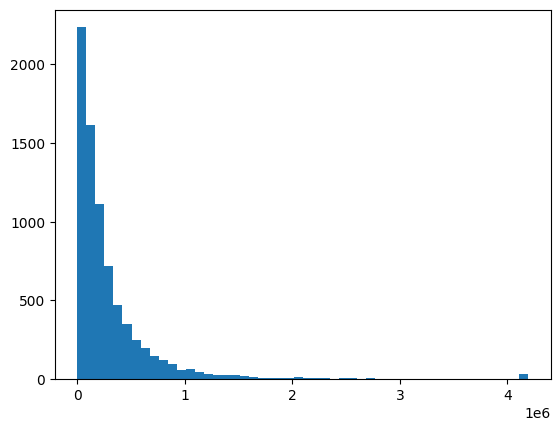

In [33]:
plt.hist(gated_cell['R2-A'],bins=50)
plt.show()

In [34]:
count = 0

for i in gated_cell['R2-A']:
    if i <= 0:
        count += 1

count

45

In [35]:
geometric_mean(gated_cell['R2-A'])

(136273.26685332373, 45, 7746)

In [36]:
f = sample.plot_scatter('SSC-A', 'R2-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_singlet_gated)
show(f)

In [37]:
geo_means = geo_mean_master_function(list)

In [40]:
display(geo_means)

Sample Name  Geometric Mean  Number of Exclusions  \
0            A1 G3-10-1      55899.4122                    10   
1               A1 UT-1        180.4204                  1742   
2            A2 G3-10-2      71341.1697                     8   
3               A2 UT-2        173.5717                   998   
4            A3 G3-10-3      77272.8760                    10   
5               A3 UT-3        180.0907                  4722   
6   A4 pDNA-CELLSCRUB-1       5386.1585                    32   
7   A5 pDNA-CELLSCRUB-2       4333.8707                   697   
8      A6 pDNA-LOTION-3       5876.1432                    48   
9              A7 LPF-1      68482.2120                    87   
10             A8 LPF-2      76070.5923                    30   
11             B1 LPF-3      91812.0972                    27   
12               B2 J-1     415966.9937                     3   
13               B3 J-2     376185.3153                     0   
14               B4 J-3     355644.7862                     5   
15              B5 S1-1      22472.1624                    18   
16              B6 S1-2      20945.4530                    19   
17              B7 S1-3      21858.6424                    17   
18              B8 B1-1       8161.4591                    54   
19              C1 B1-2       8255.3225                    17   
20              C2 B1-3       8252.1854                    34   
21            C3 G1-1-1      11465.6095                    46   
22            C4 G1-1-2       9749.5855                    38   
23            C5 G1-1-3       9844.7204                    43   
24            C6 G2-1-1      12057.7456                    29   
25            C7 G2-1-2      12102.6794                    33   
26            C8 G2-1-3      14437.1057                    24   
27            D1 G3-1-1      10966.2922                    37   
28            D2 G3-1-2      11041.8207                    32   
29            D3 G3-1-3      11574.0482                    28   
30             D4 S10-1     146405.2376                     2   
31             D5 S10-2     140414.7437                     6   
32             D6 S10-3     150526.4689                     2   
33             D7 B10-1      11114.0501                    25   
34             D8 B10-2      11270.2425                    56   
35             E1 B10-3      11489.1672                    39   
36           E2 G1-10-1     108061.4818                     5   
37           E3 G1-10-2     114581.3672                     4   
38           E4 G1-10-3     117180.4706                     6   
39           E5 G2-10-1      93621.8477                    10   
40           E6 G2-10-2      93572.1792                     1   
41           E7 G2-10-3      94066.0125                     6   

    Number of Cells  Percent Excluded  
0             16823            0.0594  
1              6977           24.9678  
2             19500            0.0410  
3              3874           25.7615  
4             18990            0.0527  
5             17374           27.1785  
6             18837            0.1699  
7             30284            2.3015  
8             21510            0.2232  
9             32273            0.2696  
10            28597            0.1049  
11            29990            0.0900  
12            19761            0.0152  
13            19147            0.0000  
14            20942            0.0239  
15            23089            0.0780  
16            19893            0.0955  
17            36422            0.0467  
18            34970            0.1544  
19            35050            0.0485  
20            35317            0.0963  
21            29900            0.1538  
22            34036            0.1116  
23            31185            0.1379  
24            24705            0.1174  
25            28273            0.1167  
26            30447            0.0788  
27            33943            0.1090  
28            28503            0.1123  
29            16

In [41]:
geo_means.to_csv('/Users/aryellewright/Documents/Documents - Aryelle’s MacBook Air/Kumar-Biomaterials-Lab/CellUptake_Plots/GeometricMeans-CorrectVertices.csv', index=False)